In [1]:
# Install required packages
!pip install kaggle
!pip install googletrans
!pip install langdetect
!pip install pycountry
!pip install scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=972d8bccb1c2336a65771e906b8b448f7010f76220aeb67ec717f09210666932
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
   

In [2]:
# Set up Kaggle and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hijest/genre-classification-dataset-imdb

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
 94% 39.0M/41.7M [00:00<00:00, 49.4MB/s]
100% 41.7M/41.7M [00:00<00:00, 46.4MB/s]


In [3]:
import zipfile
import os

with zipfile.ZipFile("genre-classification-dataset-imdb.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from googletrans import Translator
from langdetect import detect
import pycountry
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
print(os.listdir('/content/dataset'))

train = pd.read_csv(r"/content/dataset/Genre Classification Dataset/train_data.txt",
                    sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
train.head()


['Genre Classification Dataset']


,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
test = pd.read_csv(r"/content/dataset/Genre Classification Dataset/test_data.txt",
            sep=':::',names=['Title', 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [7]:
train.describe(include='object').T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [9]:
train.duplicated().sum()

0

In [10]:
train.Genre.unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [11]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [13]:
test.duplicated().sum()

0

In [14]:
train.loc[train['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [15]:
def detect_language(text):
    try:

        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train['Language'] = train['Description'].apply(detect_language)
test['Language'] = test['Description'].apply(detect_language)
train.head()

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,english
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,english
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,english
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,english
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,english


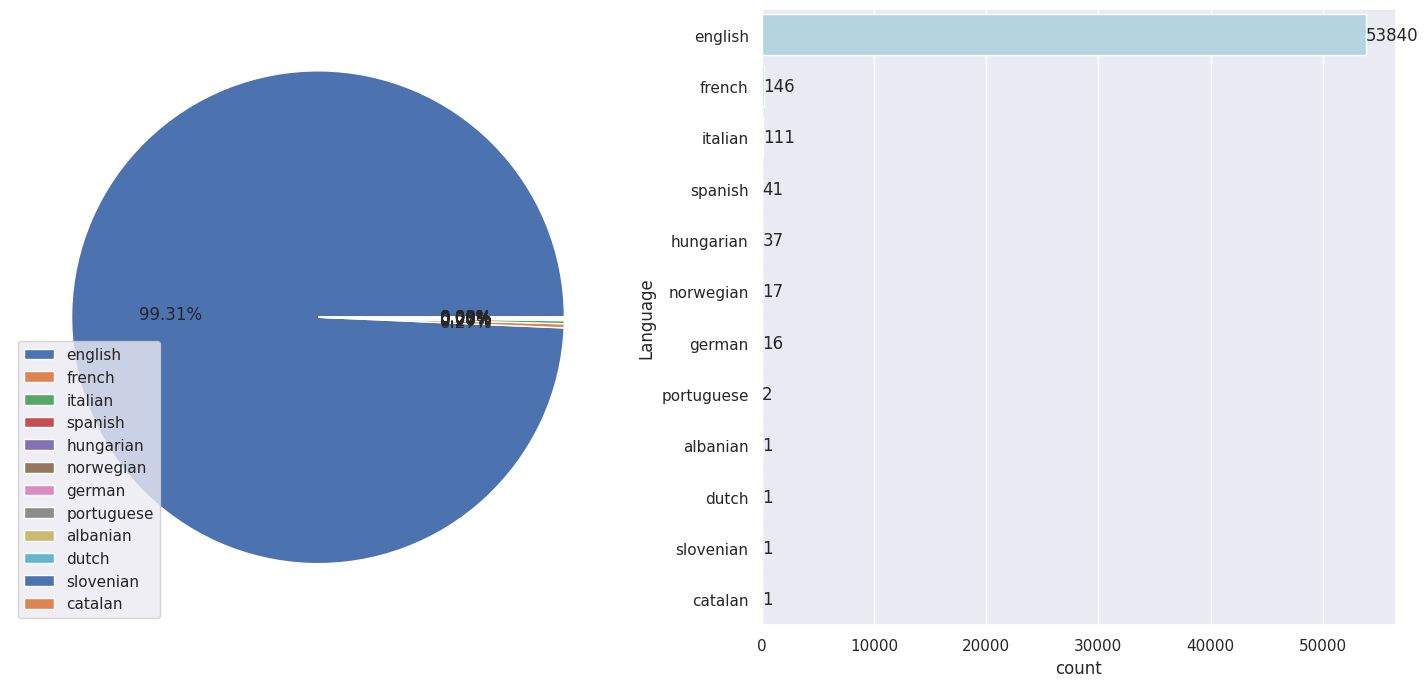

In [16]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train,y='Language',order=train.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

In [17]:
train.loc[train['Description'].str.contains(r'http\S+')].shape[0]


9

In [18]:
train.loc[train['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

In [19]:
def clean_text(text):
    # Remove strange pattern in different languages if exist
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    # Remove twitter handles
    text = re.sub(r'@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub(f'[{string.punctuation}]','',text)
    # Remove numbers
    text = re.sub(f'[{string.digits}]','',text)
    # Remove single charachters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text

In [20]:

train['Description'] = train['Description'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

train[~train.Language.isin(['english'])]

,Title,Genre,Description,Language
210,Divorzio alla siciliana (1963),comedy,Il barone Fifě ha bisogno di un erede per ave...,italian
242,Túlvilági beszélö (1992),documentary,Tollas Tibor az os fordulatot kovetoen katona...,hungarian
282,"""Boogie-woogie 47"" (1980)",drama,En plusieurs familles de Montréal passent lé...,french
678,Pallati 176 (1986),comedy,English comedy by wellknown Albanian theater ...,albanian
806,Iszony (1965),drama,Mail to author for translation Karasz Nelli a...,hungarian
...,...,...,...,...
53697,Fantasmi e ladri (1959),comedy,Annunziata ha letto diecimila gialli spopola ...,italian
53712,Due notti con Cleopatra (1954),comedy,Cleopatra č una donna bellissima ma ha un pic...,italian
53878,Gyilkos kedv (1997),drama,Kora delutan egy iskolabol hazatero kislany c...,hungarian
54165,Az áldozat (1994),documentary,Mail author for translation Az os forradalom ...,hungarian


In [21]:

def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train.loc[~train['Language'].isin(['english']), 'Description']=train.loc[~train['Language'].isin(['english']),'Description'].apply(trans)
test.loc[~test['Language'].isin(['english']), 'Description']=test.loc[~test['Language'].isin(['english']),'Description'].apply(trans)

train.drop(columns='Language',inplace=True)
test.drop(columns='Language',inplace=True)

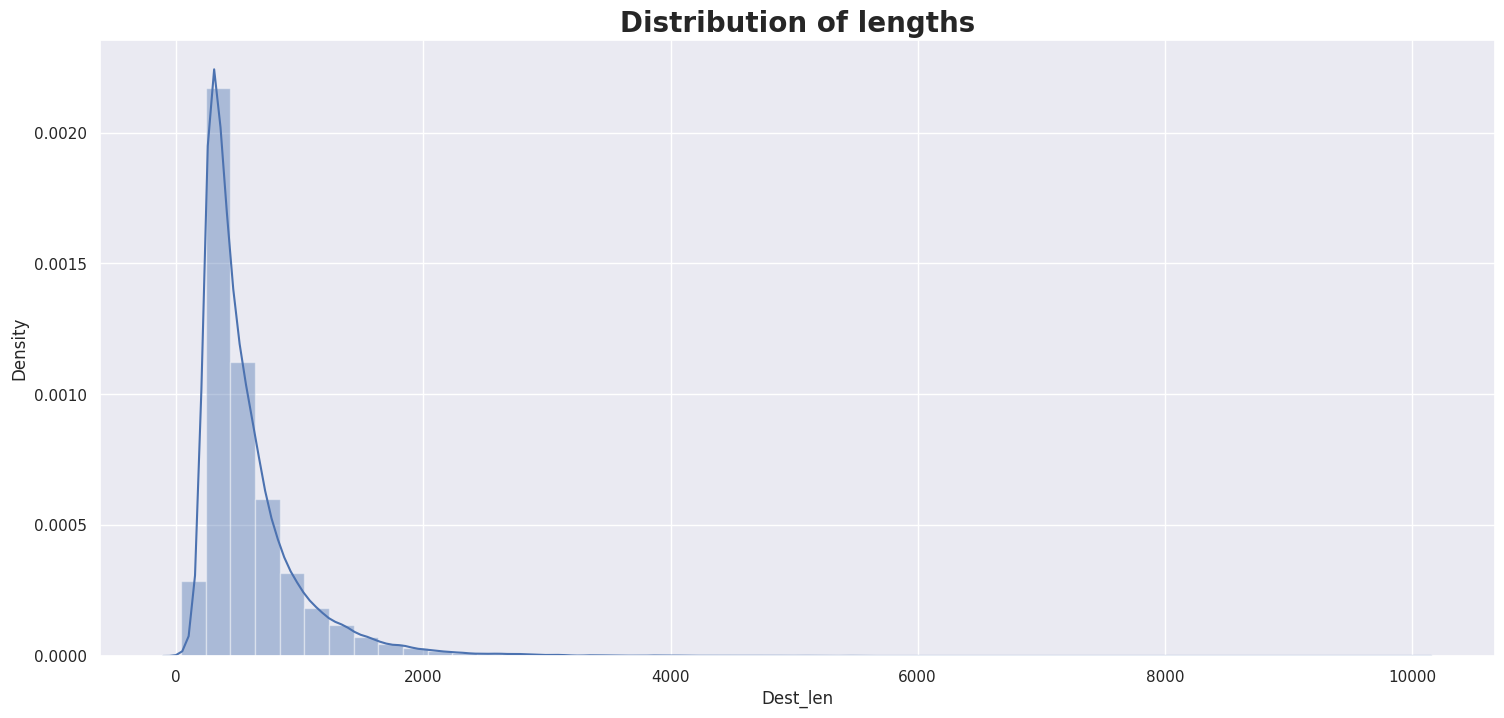

In [22]:
#Distribution of text lengths
train['Dest_len'] = train['Description'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()



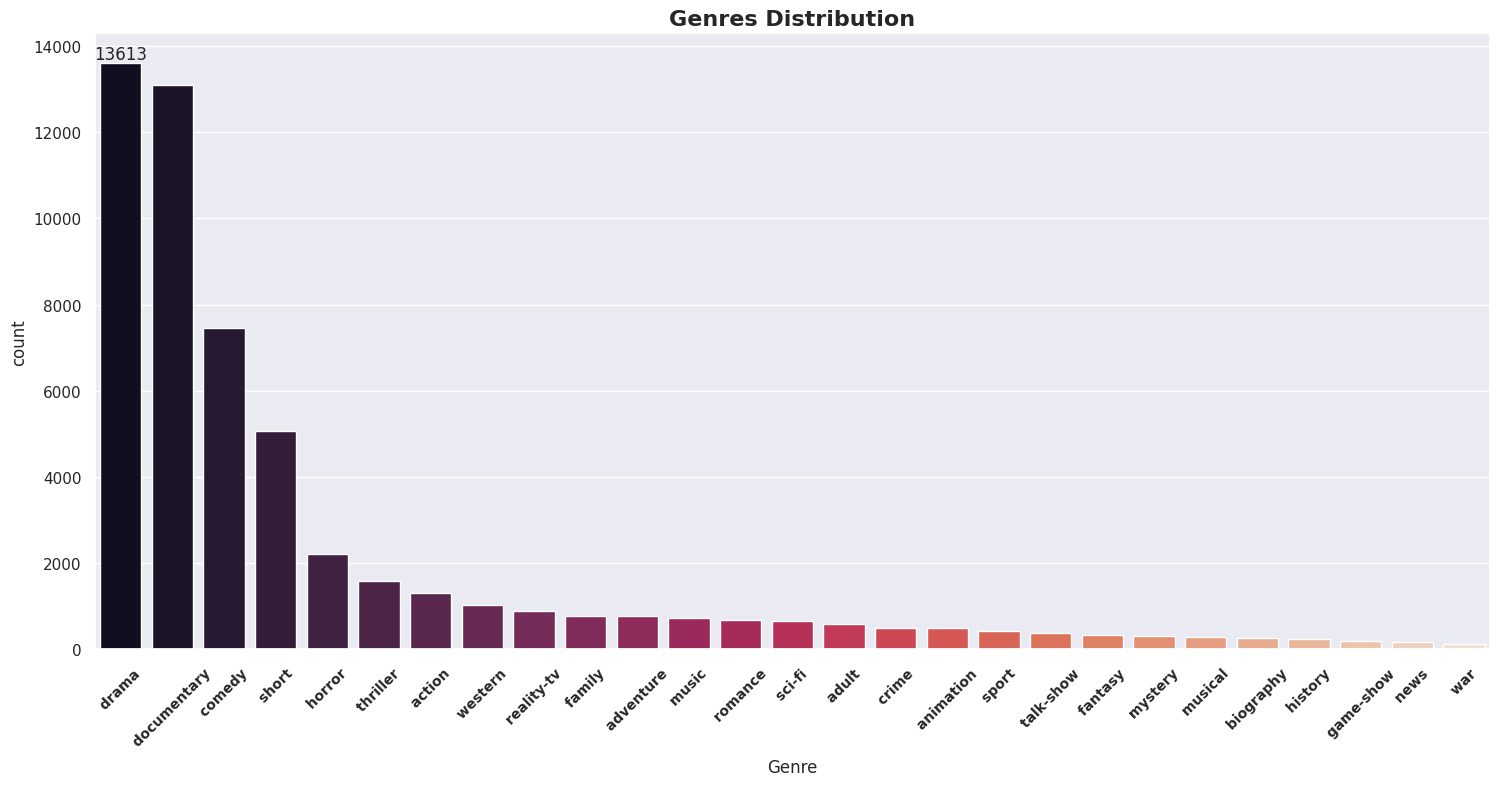

In [23]:
ax=sns.countplot(data=train,x='Genre',order=train.Genre.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
plt.title('Genres Distribution',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,fontweight='bold',fontsize=10)
plt.show()

In [24]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                        ngram_range=(1,1), #Capture only single words in each text(unigrams)
                        stop_words='english',#Remove stop_words
                        min_df=2)#Ignore words that appears less than 2 times
x_train = tfidf_vectorizer.fit_transform(train['Description'])
x_test = tfidf_vectorizer.transform(test['Description'])

In [25]:

sampler = RandomOverSampler()
x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['Genre'])

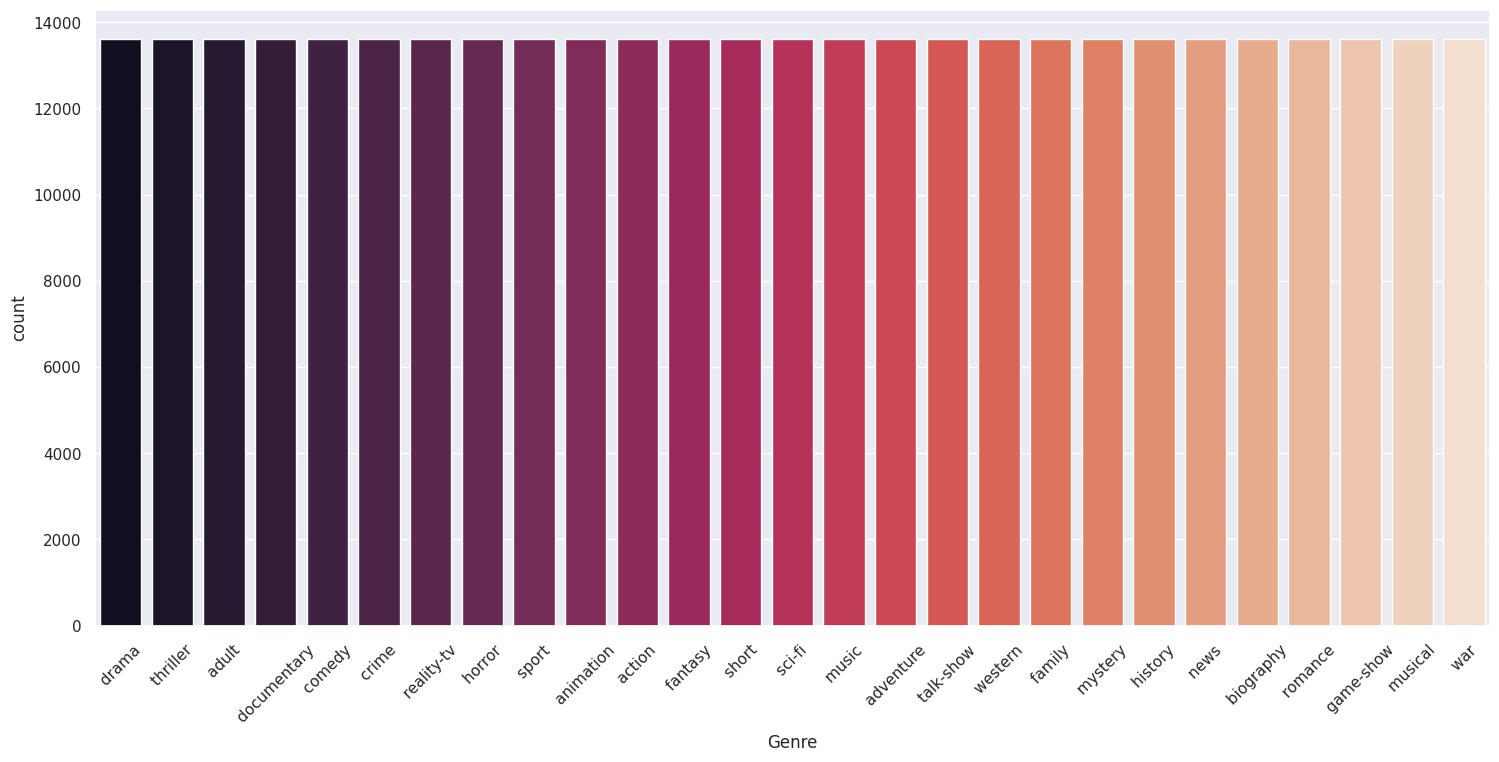

In [26]:
data = pd.DataFrame({'Genre': y_train_resampled})
sns.countplot(data=data, x='Genre', palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [27]:

print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [28]:

y_actual = pd.read_csv(r"/content/dataset/Genre Classification Dataset/test_data_solution.txt",
sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [29]:

NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Naive Bayes Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')
print(classification_report(y_actual,y_pred))

Naive Bayes Accuracy : 0.5453136531365314
Running Time :  2.54 Secounds
               precision    recall  f1-score   support

      action        0.36      0.49      0.42      1314
       adult        0.50      0.54      0.52       590
   adventure        0.32      0.24      0.27       775
   animation        0.32      0.23      0.27       498
   biography        0.04      0.03      0.03       264
      comedy        0.58      0.54      0.56      7446
       crime        0.16      0.17      0.16       505
 documentary        0.72      0.72      0.72     13096
       drama        0.64      0.57      0.60     13612
      family        0.27      0.23      0.25       783
     fantasy        0.17      0.14      0.16       322
   game-show        0.77      0.68      0.72       193
     history        0.10      0.07      0.08       243
      horror        0.52      0.68      0.59      2204
       music        0.40      0.72      0.52       731
     musical        0.17      0.09      0.12   

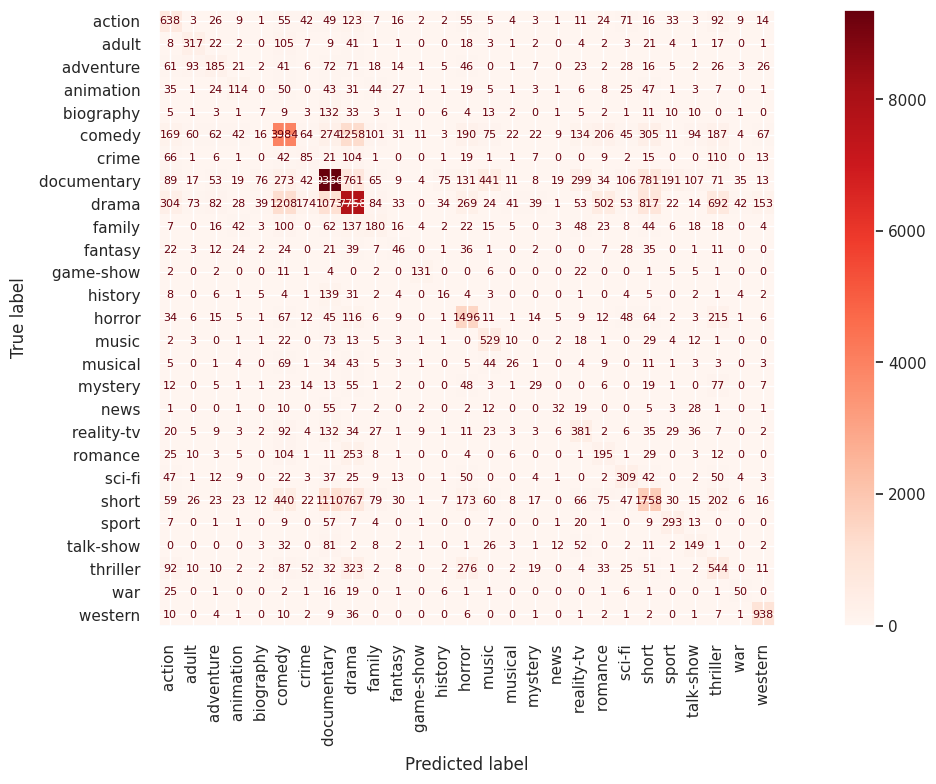

In [30]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [31]:
LR = LogisticRegression(max_iter=1000)
start_time = time()
LR.fit(x_train_resampled, y_train_resampled)
y_pred_lr = LR.predict(x_test)
print('Logistic Regression Accuracy :',accuracy_score(y_actual,y_pred_lr))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')
print(classification_report(y_actual,y_pred_lr))

Logistic Regression Accuracy : 0.5635608856088561
Running Time :  810.54 Secounds
               precision    recall  f1-score   support

      action        0.37      0.50      0.42      1314
       adult        0.49      0.58      0.53       590
   adventure        0.30      0.30      0.30       775
   animation        0.29      0.24      0.26       498
   biography        0.08      0.04      0.05       264
      comedy        0.59      0.58      0.58      7446
       crime        0.19      0.25      0.22       505
 documentary        0.77      0.72      0.74     13096
       drama        0.67      0.56      0.61     13612
      family        0.23      0.28      0.25       783
     fantasy        0.21      0.20      0.20       322
   game-show        0.75      0.70      0.72       193
     history        0.10      0.09      0.10       243
      horror        0.58      0.66      0.62      2204
       music        0.48      0.70      0.57       731
     musical        0.22      0.22   

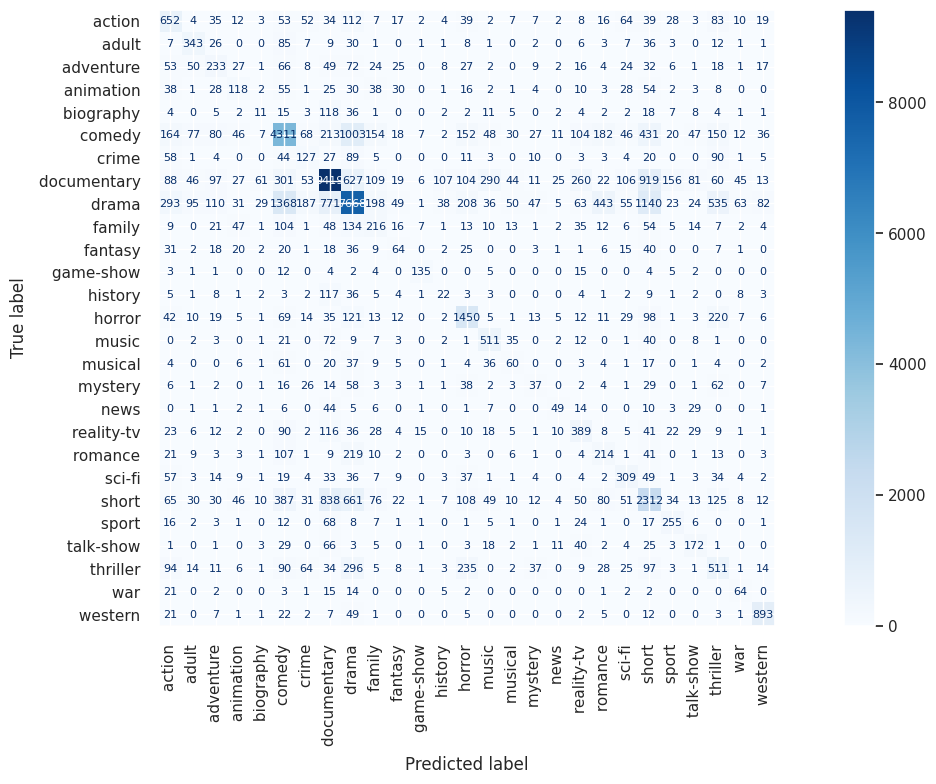

In [32]:
cm_lr =confusion_matrix(y_actual,y_pred_lr,labels=LR.classes_)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=LR.classes_)
cmd_lr.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [33]:
from sklearn.svm import LinearSVC

SVM = LinearSVC()
start_time = time()
SVM.fit(x_train_resampled, y_train_resampled)
y_pred_svm = SVM.predict(x_test)
print('SVM Accuracy :', accuracy_score(y_actual, y_pred_svm))
end_time = time()
print('Running Time : ', round(end_time - start_time, 2), 'Seconds')
print(classification_report(y_actual, y_pred_svm))


SVM Accuracy : 0.536660516605166
Running Time :  127.2 Seconds
               precision    recall  f1-score   support

      action        0.33      0.39      0.36      1314
       adult        0.50      0.50      0.50       590
   adventure        0.29      0.26      0.28       775
   animation        0.27      0.20      0.23       498
   biography        0.05      0.02      0.03       264
      comedy        0.53      0.55      0.54      7446
       crime        0.15      0.13      0.14       505
 documentary        0.72      0.73      0.73     13096
       drama        0.60      0.56      0.58     13612
      family        0.22      0.21      0.21       783
     fantasy        0.16      0.12      0.14       322
   game-show        0.72      0.68      0.70       193
     history        0.06      0.03      0.04       243
      horror        0.54      0.62      0.58      2204
       music        0.52      0.60      0.56       731
     musical        0.18      0.12      0.14       276
 

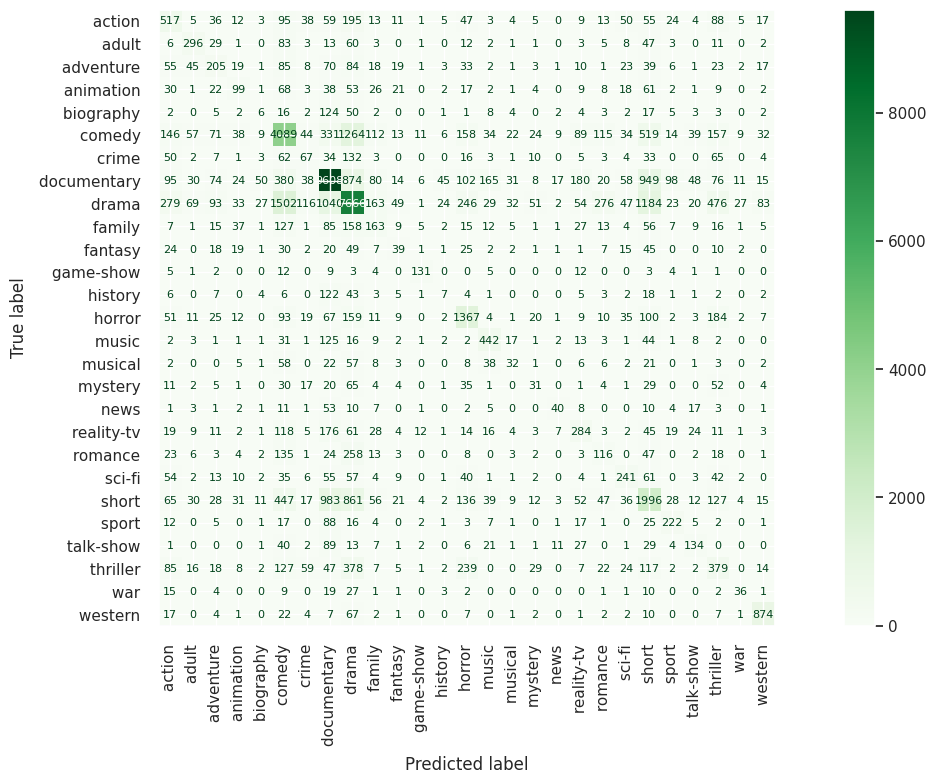

In [34]:
cm_svm =confusion_matrix(y_actual,y_pred_svm,labels=SVM.classes_)
cmd_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm,display_labels=SVM.classes_)
cmd_svm.plot(cmap=plt.cm.Greens,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [35]:
# Compare predictions
pd.concat([pd.concat([test, y_actual], axis=1),
           pd.Series(y_pred, name='Naive_Bayes_Predicted'),
           pd.Series(y_pred_lr, name='Logistic_Regression_Predicted'),
           pd.Series(y_pred_svm, name='SVM_Predicted')], axis=1).head(10)

,Title,Description,Actual_Genre,Naive_Bayes_Predicted,Logistic_Regression_Predicted,SVM_Predicted
0,Edgar's Lunch (1998),LR Brane loves his life his car his apartmen...,thriller,comedy,short,short
1,La guerra de papá (1977),Spain March Quico is very naughty child of t...,comedy,drama,drama,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary,documentary,documentary
3,Meu Amigo Hindu (2015),His father has died he hasnt spoken with his ...,drama,drama,drama,drama
4,Er nu zhai (1955),Before he was known internationally as martia...,drama,action,drama,drama
5,Riddle Room (2016),Emily Burns is being held captive in room wit...,horror,thriller,adult,adult
6,L'amica (1969),The beautiful but neglected wife of brilliant...,drama,drama,drama,drama
7,Ina Mina Dika (1989),Vasu Inamdar Ina suffers from disorder where ...,comedy,comedy,comedy,comedy
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary,documentary,documentary
9,Press (2011),Press is story of young people overwhelmed by...,drama,short,drama,documentary


In [36]:

y_train_modified = train['Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')

In [37]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Modified Naive Bayes Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Modified Naive Bayes Accuracy : 0.6947416974169742
Running Time :  0.26 Secounds
